In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import csv
import json
import requests
import bs4
from bs4 import BeautifulSoup as BS

In [3]:
def fetchmovie(ystart,yend):
    """
    Scrapes IMDB list of movie titles and parse out the Movie title and Year
    of top 150 movie titles of that year
    
    Return a list of tuples EXAMPLE :  [('TITLE', 'YEAR'),('TITLE2','YEAR2')]
    """
    lst = []
    for num in range(ystart,yend):
        link = requests.get(f'https://www.imdb.com/search/title/?year={num}&title_type=feature&').text
        soup = BS(link,'html.parser')
        h3 = soup.findAll('h3',class_='lister-item-header')
        
        for item in h3:
            x = (item.text.strip())
            lst.append(x[3:-6] + x[-6:])
    
        lst = [i.replace('\n',"") for i in lst]
        
    #run again for page 2     
    for num in range(ystart,yend):
        link = requests.get(f'https://www.imdb.com/search/title/?title_type=feature&year={num}-01-01,{num}-12-31&start=51&ref_=adv_nxt').text
        soup = BS(link,'html.parser')
        h3 = soup.findAll('h3',class_='lister-item-header')
        
        for item in h3:
            x = (item.text.strip())
            lst.append(x[3:-6] + x[-6:])

        lst = [i.replace('\n',"") for i in lst]
    
    #repeat for page 3
    for num in range(ystart,yend):
        link = requests.get(f'https://www.imdb.com/search/title/?title_type=feature&year={num}-01-01,{num}-12-31&start=101&ref_=adv_nxt').text
        soup = BS(link,'html.parser')
        h3 = soup.findAll('h3',class_='lister-item-header')
        
        for item in h3:
            x = (item.text.strip())
            lst.append(x[4:-6] + x[-6:])

        lst = [i.replace('\n',"") for i in lst]
        
    nxt = [(movie[:-6],movie[-5:-1]) for movie in lst]
    return nxt

In [4]:
#data = fetchmovie(Year start, Year end-1)
data = fetchmovie(1990,2020)


In [5]:
#small sample test to see results
#fetchmovie(2015,2016)

In [7]:
## Unnecessary step to output the data into CSV then calling its back,
## but did it for practice


#Writes the output into a CSV file
with open('data/IMDB_Titles.csv','w') as out:
    csv_out=csv.writer(out)
    for row in data:
        csv_out.writerow(row)

        
#reading the CSV file
IMDB_Titles = pd.read_csv('data/IMDB_Titles.csv')

#4499 movie titles collected from scraping IMDB with year of release
len(IMDB_Titles)

4499

## API KEY and Test

In [8]:
def get_keys(path):
    """
    Open a directory and returning a readable json
    """
    with open(path) as f:
        return json.load(f)

In [9]:
file = get_keys("/Users/jaden/.secret/yelp_api.json")
api_key = file['tmdb_key']

In [10]:
resp = requests.get(f'https://api.themoviedb.org/3/movie/76341?api_key={api_key}')

#Returns True if successfully connected
resp.status_code == requests.codes.ok

True

## TMDB API
Using the previous data that was collected( Movie Title, Year), passing this info to the TMDB API to recieve the unique Movie ID 

In [11]:
def searchmovie(title,year):
    """
    Takes 2 arguements(title of movie, year of release) will return a tuple
    of the Title of Movie and its TMDB ID (IF FOUND) 
    """
    params = {'api_key': api_key,
             'query' :title,
             'year':year}
    response = requests.get(f'https://api.themoviedb.org/3/search/movie', params = params)
    if response.ok:
        try:
            content = json.loads(response.content)
            movie_title = content['results'][0]['title']
            movie_id = content['results'][0]['id']
#             print(f'Found {movie_title} with ID {movie_id}')
            return movie_id,movie_title
        except:
            return None
    else:
        print("Bad Response")
        print(response.content)
        return None

In [12]:
#Testing Function
searchmovie("How to Train Your Dragon",'2010')

(10191, 'How to Train Your Dragon')

In [13]:
#Passing movie_title and year into the function searchmovie() then appending
#to a list 

# for num in range(len(movies_list)):
ids_lst = []
for num in range(len(data)):
    ids_lst.append(searchmovie(data[num][0],data[num][1]))

In [14]:
#Movies that werent found will be a Nonetype in ids_lst, so I had to remove it

#removing None types from list
ids_lst = [i for i in ids_lst if i]
len(ids_lst)

#Lost about 300 titles (4499-4205)

4205

In [15]:
def get_movie_details(movieID):
    """
    When passed a movieID, if valid, makes a request to the API and returns a detailed info on that movie
    """
    response = requests.get(f'https://api.themoviedb.org/3/movie/{movieID}?api_key={api_key}&language=en-US')
    if response.ok:
        return json.loads(response.content)
    else:
        return None
#testing example    
get_movie_details(10191)


{'adult': False,
 'backdrop_path': '/kxklJL1v8MYEU5xdU6W5VvmBwVz.jpg',
 'belongs_to_collection': {'id': 89137,
  'name': 'How to Train Your Dragon Collection',
  'poster_path': '/268eZwmFTScTdWlLIQl0ojewOBV.jpg',
  'backdrop_path': '/mvcfPkOvgDJG2lEAxTz0NKqoQLo.jpg'},
 'budget': 165000000,
 'genres': [{'id': 14, 'name': 'Fantasy'},
  {'id': 12, 'name': 'Adventure'},
  {'id': 16, 'name': 'Animation'},
  {'id': 10751, 'name': 'Family'}],
 'homepage': 'http://www.howtotrainyourdragon.com/',
 'id': 10191,
 'imdb_id': 'tt0892769',
 'original_language': 'en',
 'original_title': 'How to Train Your Dragon',
 'overview': 'As the son of a Viking leader on the cusp of manhood, shy Hiccup Horrendous Haddock III faces a rite of passage: he must kill a dragon to prove his warrior mettle. But after downing a feared dragon, he realizes that he no longer wants to destroy it, and instead befriends the beast – which he names Toothless – much to the chagrin of his warrior father',
 'popularity': 24.175,
 

In [16]:
def parse_movie_details(movie):
    """
    parsing the returned json
    """
    movie_data = {}
    movie_data['movie_id'] = movie['id']
    movie_data['title'] = movie['title'] if 'title' in movie.keys() else None
    movie_data['budget'] = movie['budget'] if 'budget' in movie.keys() else None
    movie_data['revenue'] = movie['revenue'] if 'revenue' in movie.keys() else None
    movie_data['popularity'] = movie['popularity'] if 'popularity' in movie.keys() else None
    movie_data['imdb_id'] = movie['imdb_id'] if 'imdb_id' in movie.keys() else None
    movie_data['release_date'] = movie['release_date'] if 'release_date' in movie.keys() else None

    movie_data['production'] = parse_production(movie['production_companies']) if 'production_companies' in movie.keys() else None
    
    movie_data['vote_avg'] = movie['vote_average'] if 'vote_average' in movie.keys() else None
    movie_data['vote_count'] = movie['vote_count'] if 'vote_count' in movie.keys() else None
    movie_data['runtime'] = movie['runtime'] if 'runtime' in movie.keys() else None
    movie_data['genres'] = parse_genres(movie['genres']) if 'genres' in movie.keys() else ''
    movie_data['dom_gross'] = movie['revenue'] if 'revenue' in movie.keys() else None
    return movie_data

def parse_genres(genre_data):
    genre_names = []
    for item in genre_data:
        if 'name' in item.keys():
            genre_names.append(item['name'])
    return ','.join(genre_names)
#     return genre_names
    
    
def parse_production(production_data):
    production = []
    for item in production_data:
        if 'name' in item.keys():
            production.append(item['name'])
    return ','.join(production)
#     return production
        

In [17]:
#testing
example = get_movie_details(10191)

parse_movie_details(example)

{'movie_id': 10191,
 'title': 'How to Train Your Dragon',
 'budget': 165000000,
 'revenue': 494878759,
 'popularity': 24.175,
 'imdb_id': 'tt0892769',
 'release_date': '2010-03-10',
 'production': 'DreamWorks Animation,Paramount',
 'vote_avg': 7.8,
 'vote_count': 8844,
 'runtime': 100,
 'genres': 'Fantasy,Adventure,Animation,Family',
 'dom_gross': 494878759}

In [18]:
#Testing
parse_movie_details(get_movie_details(ids_lst[1][0]))

{'movie_id': 114,
 'title': 'Pretty Woman',
 'budget': 14000000,
 'revenue': 463000000,
 'popularity': 22.995,
 'imdb_id': 'tt0100405',
 'release_date': '1990-03-23',
 'production': 'Touchstone Pictures,Silver Screen Partners IV',
 'vote_avg': 7.3,
 'vote_count': 4603,
 'runtime': 119,
 'genres': 'Romance,Comedy',
 'dom_gross': 463000000}

In [19]:
#Passing all the Movie ID that I previously obtained into the function
#get_movie_details() which returns a json.
# then pass that json to the function parse_movie_details to get the info
#that we need


templist = []

for num in range(len(ids_lst)):
    templist.append(parse_movie_details(get_movie_details(ids_lst[num][0])))


In [20]:
#testing to see how the list looks like before we write it to a CSV
templist[:3]

[{'movie_id': 769,
  'title': 'GoodFellas',
  'budget': 25000000,
  'revenue': 46836394,
  'popularity': 29.827,
  'imdb_id': 'tt0099685',
  'release_date': '1990-09-12',
  'production': 'Winkler Films',
  'vote_avg': 8.4,
  'vote_count': 7176,
  'runtime': 145,
  'genres': 'Drama,Crime',
  'dom_gross': 46836394},
 {'movie_id': 114,
  'title': 'Pretty Woman',
  'budget': 14000000,
  'revenue': 463000000,
  'popularity': 22.995,
  'imdb_id': 'tt0100405',
  'release_date': '1990-03-23',
  'production': 'Touchstone Pictures,Silver Screen Partners IV',
  'vote_avg': 7.3,
  'vote_count': 4603,
  'runtime': 119,
  'genres': 'Romance,Comedy',
  'dom_gross': 463000000},
 {'movie_id': 242,
  'title': 'The Godfather: Part III',
  'budget': 54000000,
  'revenue': 136766062,
  'popularity': 18.519,
  'imdb_id': 'tt0099674',
  'release_date': '1990-12-24',
  'production': 'Paramount',
  'vote_avg': 7.4,
  'vote_count': 3547,
  'runtime': 162,
  'genres': 'Crime,Drama,Thriller',
  'dom_gross': 13676

In [21]:
#writing IDs into new CSV
with open('data/tempcsv.csv','w') as out:
    csv_out=csv.writer(out)
    #this will be the column names
    csv_out.writerow(templist[0].keys())
    for row in templist:
        csv_out.writerow(row.values())

## DATA CLEANING

In [22]:
df = pd.read_csv('data/tempcsv.csv')
df.head(7)

,movie_id,title,budget,revenue,popularity,imdb_id,release_date,production,vote_avg,vote_count,runtime,genres,dom_gross
0,769,GoodFellas,25000000,46836394,29.827,tt0099685,1990-09-12,Winkler Films,8.4,7176,145.0,"Drama,Crime",46836394
1,114,Pretty Woman,14000000,463000000,22.995,tt0100405,1990-03-23,"Touchstone Pictures,Silver Screen Partners IV",7.3,4603,119.0,"Romance,Comedy",463000000
2,242,The Godfather: Part III,54000000,136766062,18.519,tt0099674,1990-12-24,Paramount,7.4,3547,162.0,"Crime,Drama,Thriller",136766062
3,861,Total Recall,65000000,261317921,19.344,tt0100802,1990-06-01,"Carolco Pictures,TriStar Pictures",7.2,3396,113.0,"Action,Adventure,Science Fiction",261317921
4,162,Edward Scissorhands,20000000,53000000,19.622,tt0099487,1990-12-05,20th Century Fox,7.7,8651,105.0,"Fantasy,Drama,Romance",53000000
5,771,Home Alone,18000000,476684675,0.899,tt0099785,1990-11-09,"Hughes Entertainment,20th Century Fox",7.3,6526,103.0,"Comedy,Family",476684675
6,581,Dances with Wolves,22000000,424208848,16.717,tt0099348,1990-03-30,"Tig Productions,Majestic Films International",7.8,2415,181.0,"Adventure,Drama,Western",424208848


In [23]:
#Spliting genres by ',' then getting the first element
df['genres_main'] = df['genres'].str.split(',')

df['genres'] = df.genres_main.map(lambda x:x[0] if type(x) == list else x)
df.head()

,movie_id,title,budget,revenue,popularity,imdb_id,release_date,production,vote_avg,vote_count,runtime,genres,dom_gross,genres_main
0,769,GoodFellas,25000000,46836394,29.827,tt0099685,1990-09-12,Winkler Films,8.4,7176,145.0,Drama,46836394,"[Drama, Crime]"
1,114,Pretty Woman,14000000,463000000,22.995,tt0100405,1990-03-23,"Touchstone Pictures,Silver Screen Partners IV",7.3,4603,119.0,Romance,463000000,"[Romance, Comedy]"
2,242,The Godfather: Part III,54000000,136766062,18.519,tt0099674,1990-12-24,Paramount,7.4,3547,162.0,Crime,136766062,"[Crime, Drama, Thriller]"
3,861,Total Recall,65000000,261317921,19.344,tt0100802,1990-06-01,"Carolco Pictures,TriStar Pictures",7.2,3396,113.0,Action,261317921,"[Action, Adventure, Science Fiction]"
4,162,Edward Scissorhands,20000000,53000000,19.622,tt0099487,1990-12-05,20th Century Fox,7.7,8651,105.0,Fantasy,53000000,"[Fantasy, Drama, Romance]"


## Is revenue and dom_gross the same?

In [24]:
df.revenue.equals(df.dom_gross)

True

## Creating new columns for (release_year) and (release_month)

In [25]:
df['release_year'] = df['release_date'].map(lambda x: x[:4])
df.head()

,movie_id,title,budget,revenue,popularity,imdb_id,release_date,production,vote_avg,vote_count,runtime,genres,dom_gross,genres_main,release_year
0,769,GoodFellas,25000000,46836394,29.827,tt0099685,1990-09-12,Winkler Films,8.4,7176,145.0,Drama,46836394,"[Drama, Crime]",1990
1,114,Pretty Woman,14000000,463000000,22.995,tt0100405,1990-03-23,"Touchstone Pictures,Silver Screen Partners IV",7.3,4603,119.0,Romance,463000000,"[Romance, Comedy]",1990
2,242,The Godfather: Part III,54000000,136766062,18.519,tt0099674,1990-12-24,Paramount,7.4,3547,162.0,Crime,136766062,"[Crime, Drama, Thriller]",1990
3,861,Total Recall,65000000,261317921,19.344,tt0100802,1990-06-01,"Carolco Pictures,TriStar Pictures",7.2,3396,113.0,Action,261317921,"[Action, Adventure, Science Fiction]",1990
4,162,Edward Scissorhands,20000000,53000000,19.622,tt0099487,1990-12-05,20th Century Fox,7.7,8651,105.0,Fantasy,53000000,"[Fantasy, Drama, Romance]",1990


In [26]:
df['release_month']=df['release_date'].map(lambda x: x[5:7])
df.head()

,movie_id,title,budget,revenue,popularity,imdb_id,release_date,production,vote_avg,vote_count,runtime,genres,dom_gross,genres_main,release_year,release_month
0,769,GoodFellas,25000000,46836394,29.827,tt0099685,1990-09-12,Winkler Films,8.4,7176,145.0,Drama,46836394,"[Drama, Crime]",1990,09
1,114,Pretty Woman,14000000,463000000,22.995,tt0100405,1990-03-23,"Touchstone Pictures,Silver Screen Partners IV",7.3,4603,119.0,Romance,463000000,"[Romance, Comedy]",1990,03
2,242,The Godfather: Part III,54000000,136766062,18.519,tt0099674,1990-12-24,Paramount,7.4,3547,162.0,Crime,136766062,"[Crime, Drama, Thriller]",1990,12
3,861,Total Recall,65000000,261317921,19.344,tt0100802,1990-06-01,"Carolco Pictures,TriStar Pictures",7.2,3396,113.0,Action,261317921,"[Action, Adventure, Science Fiction]",1990,06
4,162,Edward Scissorhands,20000000,53000000,19.622,tt0099487,1990-12-05,20th Century Fox,7.7,8651,105.0,Fantasy,53000000,"[Fantasy, Drama, Romance]",1990,12


In [49]:
#popularity score of 657? error?
df.loc[df.popularity == df1.popularity.max()]

#removeing this element, could be a mistake on the API end
df.drop(df.index[2791], inplace=True)

In [52]:
df.loc[df.popularity == df.popularity.max()]

,movie_id,title,budget,revenue,popularity,imdb_id,release_date,production,vote_avg,vote_count,runtime,genres,dom_gross,genres_main,release_year,release_month
1372,181812,Star Wars: The Rise of Skywalker,250000000,1073604458,134.095,tt2527338,2019-12-18,"Lucasfilm,Bad Robot,Walt Disney Pictures,Briti...",6.5,4182,142.0,Action,1073604458,"[Action, Adventure, Science Fiction]",2019,12


In [53]:
#changing release year from str to int
df.release_year.astype('int')

decade2010 = df.loc[df.release_year.astype('int') > 2009]
decade2010.budget.mean()

#average budget of movies from 2010-present
#used to figure out how much budget should be allocated to the movie

49009629.4515128

## DATA ANALYSIS

In [54]:
#plt style
plt.style.use('ggplot')
plt.xkcd();

## Bigger Budget == Higher Gross?

In [55]:
#Before we compare the 2 variables, I want to see how many missing values there are

df.budget.isna().sum()
df.dom_gross.isna().sum()

# In this dataset instead of Nan, its replaced with a 0
len(df.loc[df.budget == 0])#969
len(df.loc[df.dom_gross == 0])#870


#Selecting only the movies that have values > 0 
df1 = df.loc[(df.budget !=0) & (df.dom_gross != 0)]

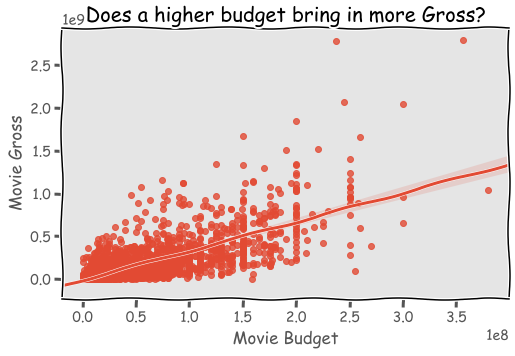

In [56]:
fig = plt.figure(figsize= (8,5))
sns.regplot(df1['budget'],df1['dom_gross'])
plt.xlabel('Movie Budget')
plt.ylabel('Movie Gross')
plt.title('Does a higher budget bring in more Gross?');

## Groupby Genre

In [57]:
#groupping dataset by month
#all numerical columns will have mean/avg calculated

groupedgenre = df1.groupby('genres').mean().reset_index()
groupedgenre

,genres,movie_id,budget,revenue,popularity,vote_avg,vote_count,runtime,dom_gross
0,Action,86722.569444,7.072542e+07,2.134482e+08,16.629653,6.284201,3132.588542,112.730903,2.134482e+08
1,Adventure,64846.777778,9.498361e+07,3.221600e+08,19.211352,6.559770,4071.436782,117.923372,3.221600e+08
2,Animation,77294.094737,8.733440e+07,3.375124e+08,19.504263,6.836842,4084.810526,94.442105,3.375124e+08
3,Comedy,57526.533217,3.098048e+07,9.755434e+07,12.249016,6.358741,1576.085664,103.951049,9.755434e+07
4,Crime,87154.074534,3.244606e+07,8.652793e+07,14.804733,6.857143,2145.211180,120.229814,8.652793e+07
5,Drama,77859.782946,2.905740e+07,8.240480e+07,13.457377,6.914264,1855.848062,120.584496,8.240480e+07
6,Family,49347.464286,7.662857e+07,2.750758e+08,13.894214,6.335714,2961.892857,96.535714,2.750758e+08
7,Fantasy,38945.935484,6.220968e+07,1.917433e+08,15.656226,6.374194,3028.537634,107.967742,1.917433e+08
8,History,85420.416667,5.208333e+07,1.791304e+08,13.971333,7.000000,2582.833333,142.500000,1.791304e+08
9,Horror,73254.395210,2.110232e+07,7.744133e+07,13.685389,6.097006,1725.616766,100.473054,7.744133e+07


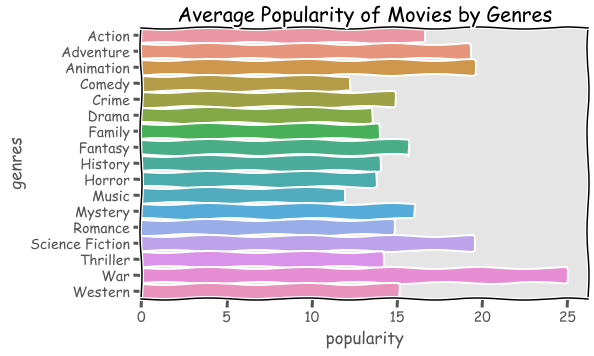

In [58]:
fig = plt.figure(figsize=(8,5))
sns.barplot(groupedgenre.popularity,groupedgenre.genres)

# for index, row in groupedgenre.iterrows():
#     c.text(row.name,row.popularity, round(row.popularity,2), color='black', ha="center")
    
plt.title('Average Popularity of Movies by Genres');

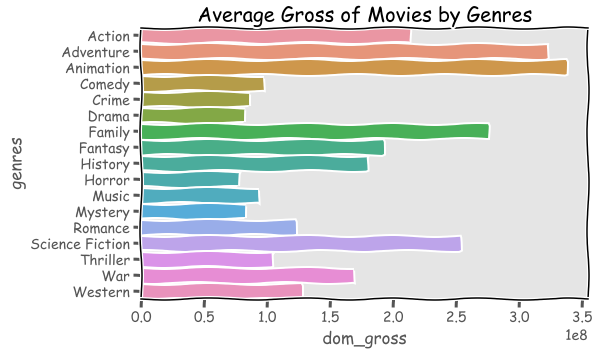

In [59]:
#dom_gross based on genres

fig = plt.figure(figsize=(8,5))
sns.barplot(groupedgenre.dom_gross,groupedgenre.genres)
  
plt.title('Average Gross of Movies by Genres');

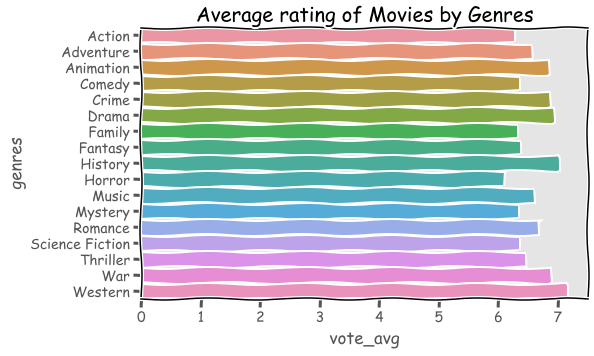

In [60]:
fig = plt.figure(figsize=(8,5))
sns.barplot(groupedgenre.vote_avg,groupedgenre.genres)
  
plt.title('Average rating of Movies by Genres');

<Figure size 576x360 with 0 Axes>

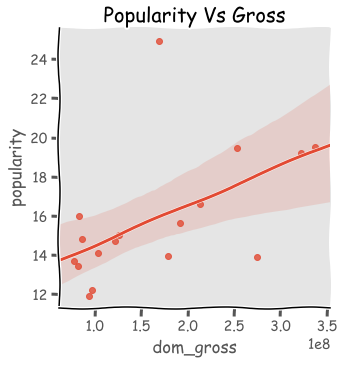

In [61]:
fig = plt.figure(figsize=(8,5))
sns.lmplot('dom_gross','popularity',groupedgenre)
plt.title('Popularity Vs Gross');

<Figure size 576x576 with 0 Axes>

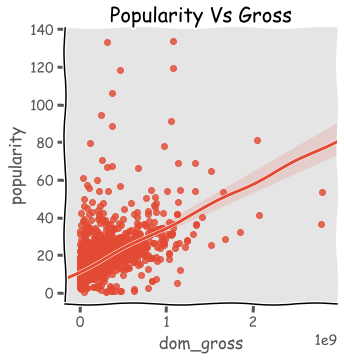

In [63]:
fig = plt.figure(figsize=(8,8))
sns.lmplot('dom_gross','popularity',df1)
plt.title('Popularity Vs Gross');

## Groupby Month

In [36]:
#groupping dataset by month
#all numerical columns will have mean/avg calculated

groupedvalues = df1.groupby('release_month').mean().reset_index()
groupedvalues

,release_month,movie_id,budget,revenue,popularity,vote_avg,vote_count,runtime,dom_gross
0,01,77524.312500,3.092588e+07,7.619907e+07,13.124438,6.282639,1535.166667,105.847222,7.619907e+07
1,02,65935.429348,3.952516e+07,1.101759e+08,13.693033,6.434239,2148.282609,109.429348,1.101759e+08
2,03,67380.553571,4.822268e+07,1.373145e+08,14.442924,6.433929,2343.482143,110.000000,1.373145e+08
3,04,56997.438424,4.785107e+07,1.632000e+08,14.215975,6.348768,2395.950739,108.162562,1.632000e+08
4,05,73473.348739,6.825782e+07,2.323674e+08,16.319202,6.592017,3263.373950,114.924370,2.323674e+08
5,06,75969.751880,7.022425e+07,2.492417e+08,15.745086,6.395865,3113.627820,110.733083,2.492417e+08
6,07,65636.623574,5.648791e+07,1.830870e+08,15.484125,6.504183,2783.961977,112.045627,1.830870e+08
7,08,65768.541176,3.665438e+07,9.140081e+07,13.273404,6.318824,1637.270588,107.047059,9.140081e+07
8,09,65826.513932,2.860089e+07,7.341210e+07,15.368099,6.676161,1854.464396,110.721362,7.341210e+07
9,10,87157.533333,3.980135e+07,1.130151e+08,15.854400,6.648889,2449.962963,112.348148,1.130151e+08


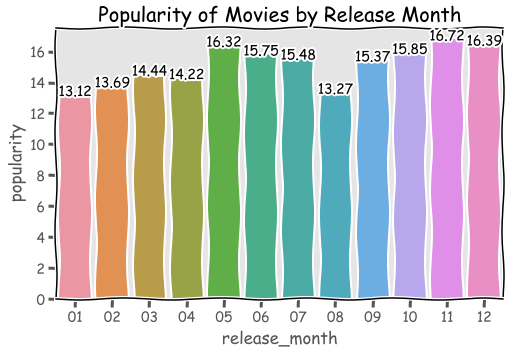

In [37]:
fig = plt.figure(figsize=(8,5))
a =  sns.barplot(groupedvalues.release_month,groupedvalues.popularity)

for index, row in groupedvalues.iterrows():
    a.text(row.name,row.popularity, round(row.popularity,2), color='black', ha="center")

plt.title('Popularity of Movies by Release Month');

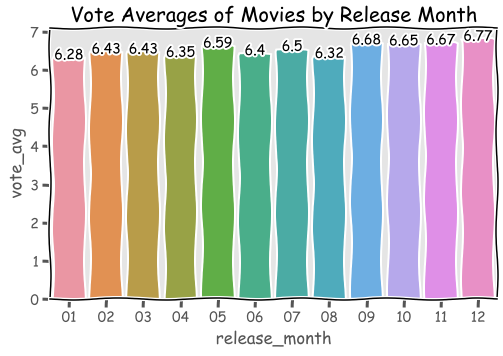

In [38]:
fig = plt.figure(figsize=(8,5))
b = sns.barplot(groupedvalues.release_month,groupedvalues.vote_avg)

for index, row in groupedvalues.iterrows():
    b.text(row.name,row.vote_avg, round(row.vote_avg,2), color='black', ha="center")
    
plt.title('Vote Averages of Movies by Release Month');

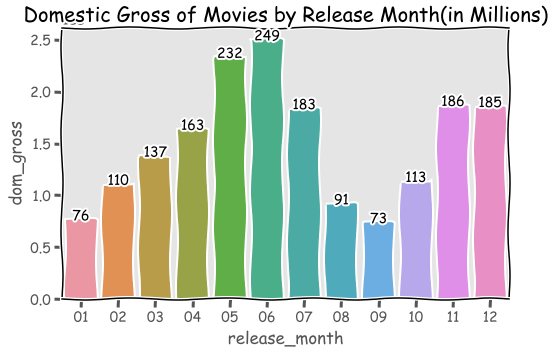

In [39]:
fig = plt.figure(figsize=(8,5))
c = sns.barplot(groupedvalues.release_month,groupedvalues.dom_gross)

for index, row in groupedvalues.iterrows():
    c.text(row.name,row.dom_gross, round(row.dom_gross//1000000), color='black', ha="center")
    
plt.title('Domestic Gross of Movies by Release Month(in Millions)');

,movie_id,title,budget,revenue,popularity,imdb_id,release_date,production,vote_avg,vote_count,runtime,genres,dom_gross,genres_main,release_year,release_month
2791,419704,Ad Astra,87500000,127175922,657.427,tt2935510,2019-09-17,"New Regency Productions,Keep Your Head,MadRive...",6.0,3145,123.0,Science Fiction,127175922,"[Science Fiction, Drama]",2019,09
